In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 128)          2560000   
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 3)                 195       
                                                                 
Total params: 2,601,347
Trainable params: 2,601,347
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
207/207 [==============================] - 9s 42ms/step - loss: 1.1117 - accuracy: 0.3388 - val_loss: 1.1134 - val_accuracy: 0.3363
Epoch 2/5
207/207 [==============

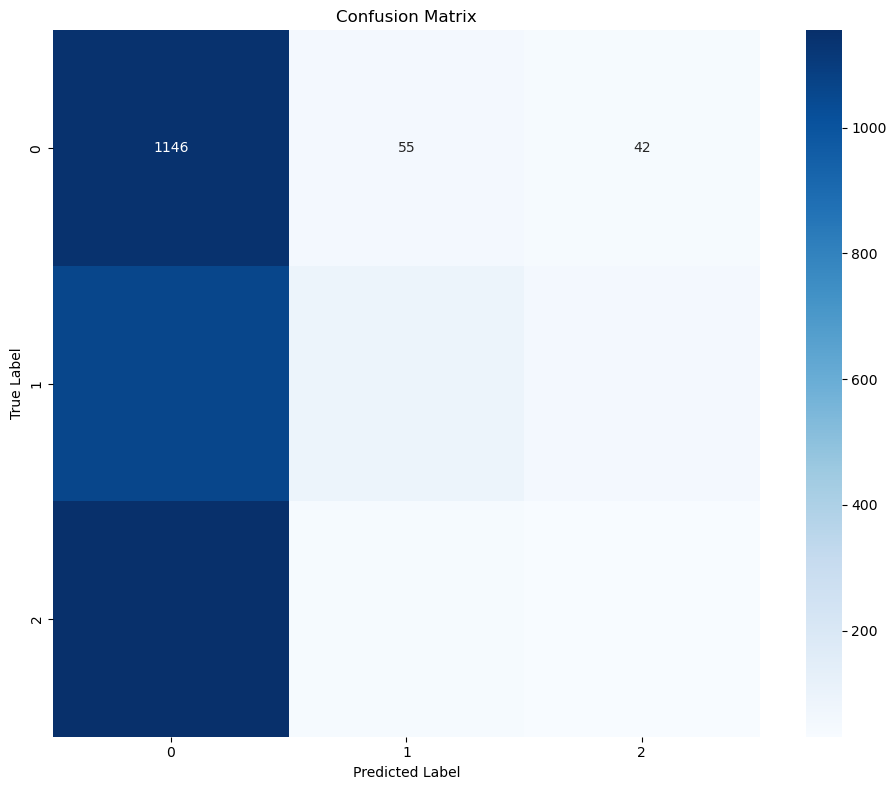

In [ ]:

df = pd.read_parquet("../../datasets/amazon_user_reviews_text_sentiment.parquet")

# Ensure correct columns
texts = df["text_cleaned"].astype(str).values
labels = df["sentiment"].values

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

max_vocab_size = 20000
max_length = 100

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding="post")


model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_length),
    SimpleRNN(128),
    Dense(64, activation="relu"),
    Dense(3, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

history = model.fit(
    X_train_pad,
    y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=64
)

preds = model.predict(X_test_pad)
y_pred = np.argmax(preds, axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)